# Load Data and PKGs

## Pkgs

In [1]:
from os import getcwd as gwd
from os import chdir as cd
from itertools import combinations 
from scipy.stats import pearsonr as pr
from scipy.stats import zscore as zscore
from scipy.stats import ttest_rel as ttest
from scipy.stats import t as student_t
from scipy.optimize import curve_fit
from scipy.special import i0, gamma
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2
%load_ext rpy2.ipython
np.random.seed(223)
subjs = ['test']
# realEcc = 0.36
# analysisInput = 4 # 1 for angular errors, 2 for RT, 3 for distortion indices, 4 for eccentricity errors

## Global Util Func

In [51]:
# Replace outliers by mean
def clrOutlier(data):
    mu = np.mean(data,axis=None)
    sd = np.std(data,axis=None)
    ind1 = np.nonzero(data<float(mu-3*sd))
    if len(ind1) != 0:
        data[ind1] = mu
    ind2 = np.nonzero(data>float(mu+3*sd))
    if len(ind2) != 0:
        data[ind2] = mu
    return data

def calSlope(avgHalf,win=7):
    last = len(avgHalf)-1
    shiftErr = pd.Series(avgHalf[last]).append(avgHalf[0:last])
    shiftErr.index = np.arange(last+1)
    slope = avgHalf-shiftErr
    return circ_moving_average(slope,win)

def circ_moving_average(a, n=7,circ=True) :
    if circ:
        a1 = a[-(n-1)//2:].append(a).append(a[:(n-1)//2])
    else:
        a1 = a
    a1 = np.array(a1)
    ret = np.cumsum(a1)
    ret[n:] = ret[n:] - ret[:-n]
    return pd.Series(ret[n - 1:] / n)

# generate random indices
def genRandInd(reps=8,subjNum = 1):
    indices = None
    angNum = 48
    for ss in range(subjNum):
        for angle in range(angNum):
            randInd = np.random.choice(reps,reps//2,replace=False)+angle*reps+ss*angNum*reps
            if indices is not None:
                indices = np.hstack((indices,randInd))
            else:
                indices = randInd       
    return np.array(indices)

# average each half
def avgHalf(df,indices):
    half1 = df.loc[indices,:]
    half2 = df.drop(indices)
    resultDF = pd.DataFrame()
    resultDF['half1'] = np.array(half1.groupby(by='locs').errors.mean())
    resultDF['half2']  = np.array(half2.groupby(by='locs').errors.mean())
    return resultDF

# morph the location difference
def recenter(x, threshold=24):
    for i in range(len(x)):
        if x[i] > threshold - 1:
            x[i] = x[i] - 2 * threshold
        elif x[i] < -threshold:
            x[i] = x[i] + 2 * threshold
    return x

## Angular Error Data

In [3]:
dataAll = dict()
for subjName in subjs:
    data = pd.read_csv((subjName+'.csv'),header=None,names=['age','gender','x','y','ang'],usecols=[11,17,26,27,35])
    data = data[-pd.isnull(data.x)]
    data = data[1:(len(data)+1)]
    data.index = range(len(data))
    data.ang = data.ang.astype(float)
    data.x = data.x.astype(float)
    data.y = data.y.astype(float)
    data['stim'] = data.ang<48 #True for noise, False for face
    data.loc[data.gender=='F','gender'] = 'Female'
    dataAll[subjName] = data

In [4]:
dataAll['EW'].head()

,age,gender,x,y,ang,stim
0,21,Male,-0.170573,-0.326823,81.0,False
1,21,Male,-0.281250,0.285156,18.0,True
2,21,Male,-0.410156,-0.110677,74.0,False
3,21,Male,-0.368490,-0.029948,73.0,False
4,21,Male,0.092448,0.317708,10.0,True


### Functions for Preprocessing

In [5]:
# calculate angular response
def calAng(x,y):
    angResp = np.rad2deg(np.arctan2(y,x))
    if angResp < 0:
        angResp = 360+angResp
    return angResp

# Morph errors
def morphErr(err):
    if err > 180:
        err = -360+err
    else:
        if err < (-180):
            err = 360+err
    return err

### Preprocessing

In [6]:
def preprocessPerSubj(data):
    angErr=list()
    for trial in range(0,data.shape[0]):
        if data.ang[trial] < 48:
            err = morphErr(calAng(data.x[trial],data.y[trial])-data.ang[trial]*7.5)
        else:
            err = morphErr(calAng(data.x[trial],data.y[trial])-(data.ang[trial]-48)*7.5)
        angErr.append(err)
    angErr = clrOutlier(np.array(angErr))
    return angErr

In [7]:
errNoise = dict()
errFace = dict()
errAll = pd.DataFrame()
for subj in subjs:   
    errs = pd.DataFrame(data = preprocessPerSubj(dataAll[subj]),columns=['errors'])
    errs['locs'] = dataAll[subj].ang
    errs['stim'] = dataAll[subj].stim
#     errs = errs.sort_values(['locs','stim'])
    errs.index = range(len(errs))
    errs['subj'] = subj
    errAll = pd.concat([errAll,errs])
    errs = errs.drop(columns='subj')
    errNoise[subj] = errs.loc[errs.stim,'errors':'locs'].reset_index(drop=True)
    errFace[subj] = errs.loc[~errs.stim,'errors':'locs']
    errFace[subj].locs = errFace[subj].locs-48
    errFace[subj].index = range(errs.shape[0]//2)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

## Reaction Time Data

In [8]:
rtNoise = dict()
rtFace = dict()
rtAll = pd.DataFrame()
for subjName in subjs:
    data = pd.read_csv((subjName+'.csv'),header=None,names=['errors','locs'],usecols=[31,35]) # Note that now "errors" are rt
    data = data[-pd.isnull(data.errors)]
    data = data[1:len(data.errors)]
    data = data.astype(float)
    data.errors = clrOutlier(np.array(data.errors))
#     data = data.sort_values('locs')
    data['stim'] = data.locs<48
    data['subj'] = subjName
    rtAll = pd.concat([rtAll,data])
    data = data.drop(columns='subj')
    rtNoise[subjName] = data.loc[data.stim,'errors':'locs']
    rtNoise[subjName].index = range(len(data.errors)//2)
    rtFace[subjName] = data.loc[~data.stim,'error':'locs']
    rtFace[subjName].locs = rtFace[subjName].locs - 48
    rtFace[subjName].index = range(len(data.errors)//2)

## Eccentricity Errors

In [9]:
def calDistance(x,y):
    return np.sqrt(x*x+y*y)

def eccErrorPerSubj(data):
    eccErr=list()
    for trial in range(0,data.shape[0]):
        eccErr.append(calDistance(data.x[trial],data.y[trial])-realEcc)
    eccErr = clrOutlier(np.array(eccErr))
    return eccErr

In [10]:
eccNoise = dict()
eccFace = dict()
eccAll = pd.DataFrame()
for subj in subjs:   
    errs = pd.DataFrame(data = eccErrorPerSubj(dataAll[subj]),columns=['errors'])
    errs['locs'] = dataAll[subj].ang
    errs['stim'] = dataAll[subj].stim
#     errs = errs.sort_values(['locs','stim'])
    errs.index = range(len(errs))
    errs['subj'] = subj
    eccAll = pd.concat([eccAll,errs])
    errs = errs.drop(columns='subj')
    eccNoise[subj] = errs.loc[errs.stim,'errors':'locs']
    eccFace[subj] = errs.loc[~errs.stim,'errors':'locs']
    eccFace[subj].locs = eccFace[subj].locs-48
    eccFace[subj].index = range(errs.shape[0]//2)

# Within-subject correlations

## functions

In [11]:
# shift a half for a random phase
# half must be a numpy array
def shiftHalf(half):
    randPhase = np.int(np.random.choice(len(half),1))
    if randPhase == 0:
        return half
    else:
        if randPhase == len(half)-1:
            half = np.concatenate(([half[randPhase]],half[range(randPhase)]))
            return half
        else:
            half = np.concatenate((half[range(randPhase,np.int(len(half)))],half[range(randPhase)]))
            return half

## Bootstrap Within

In [12]:
def avgSplitHalf(errAll,DI = False,perm=False,reps=8,allSubj = subjs):
    allRVals = list()
    for subj in allSubj:
        twoHalves = avgHalf(errAll[subj].sort_values('locs').reset_index(drop=True),genRandInd(reps))
        half2 = twoHalves.half2
        if perm:
            half2 = pd.Series(shiftHalf(np.array(half2)))
        if DI:
            [r,p]=pr(calSlope(twoHalves.half1),calSlope(half2))
        else:
            [r,p]=pr(twoHalves.half1,half2)
        allRVals.append(r)
    allRVals = np.array(allRVals)
    return np.tanh(np.mean(np.arctanh(allRVals)))

def avgBtwCondWithin(nb,face,DI,perm=False,reps=8,allSubj = subjs):
    allRVals = list()
    for subj in allSubj:
        twoHalves_nb = avgHalf(nb[subj].sort_values('locs').reset_index(drop=True),genRandInd(reps))
        twoHalves_face = avgHalf(face[subj].sort_values('locs').reset_index(drop=True),genRandInd(reps))
        half2 = twoHalves_face.half1
        if perm:
            half2 = pd.Series(shiftHalf(np.array(half2)))
        if DI:
            [r,p]=pr(calSlope(twoHalves_nb.half1),calSlope(half2))
        else:
            [r,p]=pr(twoHalves_nb.half1,half2)
        allRVals.append(r)
    allRVals = np.array(allRVals)
    return np.tanh(np.mean(np.arctanh(allRVals)))

In [13]:
bootWithinR = dict()
bootWithinR['nb'] = list()
bootWithinR['face'] = list()
bootWithinR['btwCond'] = list()
DI = False
iters = 1000
for it in range(iters):
    if analysisInput == 1:
        inputNoise = errNoise
        inputFace = errFace
    elif analysisInput == 2:
        inputNoise = rtNoise
        inputFace = rtFace
    elif analysisInput == 3:
        inputNoise = errNoise
        inputFace = errFace
        DI = True
    else:
        inputNoise = eccNoise
        inputFace = eccFace
    bootWithinR['nb'].append(avgSplitHalf(inputNoise,DI))
    bootWithinR['face'].append(avgSplitHalf(inputFace,DI))
    bootWithinR['btwCond'].append(avgBtwCondWithin(inputNoise,inputFace,DI))  
    print(it,'out of', iters, 'iterations')

0 out of 1000 iterations
1 out of 1000 iterations
2 out of 1000 iterations
3 out of 1000 iterations
4 out of 1000 iterations
5 out of 1000 iterations
6 out of 1000 iterations
7 out of 1000 iterations
8 out of 1000 iterations
9 out of 1000 iterations
10 out of 1000 iterations
11 out of 1000 iterations
12 out of 1000 iterations
13 out of 1000 iterations
14 out of 1000 iterations
15 out of 1000 iterations
16 out of 1000 iterations
17 out of 1000 iterations
18 out of 1000 iterations
19 out of 1000 iterations
20 out of 1000 iterations
21 out of 1000 iterations
22 out of 1000 iterations
23 out of 1000 iterations
24 out of 1000 iterations
25 out of 1000 iterations
26 out of 1000 iterations
27 out of 1000 iterations
28 out of 1000 iterations
29 out of 1000 iterations
30 out of 1000 iterations
31 out of 1000 iterations
32 out of 1000 iterations
33 out of 1000 iterations
34 out of 1000 iterations
35 out of 1000 iterations
36 out of 1000 iterations
37 out of 1000 iterations
38 out of 1000 iterati

309 out of 1000 iterations
310 out of 1000 iterations
311 out of 1000 iterations
312 out of 1000 iterations
313 out of 1000 iterations
314 out of 1000 iterations
315 out of 1000 iterations
316 out of 1000 iterations
317 out of 1000 iterations
318 out of 1000 iterations
319 out of 1000 iterations
320 out of 1000 iterations
321 out of 1000 iterations
322 out of 1000 iterations
323 out of 1000 iterations
324 out of 1000 iterations
325 out of 1000 iterations
326 out of 1000 iterations
327 out of 1000 iterations
328 out of 1000 iterations
329 out of 1000 iterations
330 out of 1000 iterations
331 out of 1000 iterations
332 out of 1000 iterations
333 out of 1000 iterations
334 out of 1000 iterations
335 out of 1000 iterations
336 out of 1000 iterations
337 out of 1000 iterations
338 out of 1000 iterations
339 out of 1000 iterations
340 out of 1000 iterations
341 out of 1000 iterations
342 out of 1000 iterations
343 out of 1000 iterations
344 out of 1000 iterations
345 out of 1000 iterations
3

614 out of 1000 iterations
615 out of 1000 iterations
616 out of 1000 iterations
617 out of 1000 iterations
618 out of 1000 iterations
619 out of 1000 iterations
620 out of 1000 iterations
621 out of 1000 iterations
622 out of 1000 iterations
623 out of 1000 iterations
624 out of 1000 iterations
625 out of 1000 iterations
626 out of 1000 iterations
627 out of 1000 iterations
628 out of 1000 iterations
629 out of 1000 iterations
630 out of 1000 iterations
631 out of 1000 iterations
632 out of 1000 iterations
633 out of 1000 iterations
634 out of 1000 iterations
635 out of 1000 iterations
636 out of 1000 iterations
637 out of 1000 iterations
638 out of 1000 iterations
639 out of 1000 iterations
640 out of 1000 iterations
641 out of 1000 iterations
642 out of 1000 iterations
643 out of 1000 iterations
644 out of 1000 iterations
645 out of 1000 iterations
646 out of 1000 iterations
647 out of 1000 iterations
648 out of 1000 iterations
649 out of 1000 iterations
650 out of 1000 iterations
6

919 out of 1000 iterations
920 out of 1000 iterations
921 out of 1000 iterations
922 out of 1000 iterations
923 out of 1000 iterations
924 out of 1000 iterations
925 out of 1000 iterations
926 out of 1000 iterations
927 out of 1000 iterations
928 out of 1000 iterations
929 out of 1000 iterations
930 out of 1000 iterations
931 out of 1000 iterations
932 out of 1000 iterations
933 out of 1000 iterations
934 out of 1000 iterations
935 out of 1000 iterations
936 out of 1000 iterations
937 out of 1000 iterations
938 out of 1000 iterations
939 out of 1000 iterations
940 out of 1000 iterations
941 out of 1000 iterations
942 out of 1000 iterations
943 out of 1000 iterations
944 out of 1000 iterations
945 out of 1000 iterations
946 out of 1000 iterations
947 out of 1000 iterations
948 out of 1000 iterations
949 out of 1000 iterations
950 out of 1000 iterations
951 out of 1000 iterations
952 out of 1000 iterations
953 out of 1000 iterations
954 out of 1000 iterations
955 out of 1000 iterations
9

In [14]:
inputFace['KH']

,errors,locs
0,0.003610,14.0
1,-0.021153,44.0
2,-0.001891,19.0
3,-0.026859,42.0
4,0.003666,22.0
5,-0.036005,20.0
6,-0.029462,26.0
7,-0.005305,31.0
8,-0.000410,32.0
9,-0.022820,43.0


In [15]:
meanBootWithinR = [np.tanh(np.mean(np.arctanh(bootWithinR['nb']))),\
                   np.tanh(np.mean(np.arctanh(bootWithinR['face']))),\
                  np.tanh(np.mean(np.arctanh(bootWithinR['btwCond'])))]
bootWithinCI = [[np.sort(bootWithinR['nb'])[np.int(iters*.025-1)],\
                 np.sort(bootWithinR['nb'])[np.int(iters*.975-1)]],\
               [np.sort(bootWithinR['face'])[np.int(iters*.025-1)],\
                np.sort(bootWithinR['face'])[np.int(iters*.975-1)]],\
               [np.sort(bootWithinR['btwCond'])[np.int(iters*.025-1)],\
                np.sort(bootWithinR['btwCond'])[np.int(iters*.975-1)]]]
print('Bootstrap Within Results')
print('NoisePatch: mean r =',meanBootWithinR[0],'95% CI =','[',bootWithinCI[0][0],bootWithinCI[0][1],']')
print('Face: mean r =',meanBootWithinR[1],'95% CI =','[',bootWithinCI[1][0],bootWithinCI[1][1],']')
print('Between NP and Face: mean r =',meanBootWithinR[2],'95% CI =','[',bootWithinCI[2][0],bootWithinCI[2][1],']')

Bootstrap Within Results
NoisePatch: mean r = 0.45324871712659875 95% CI = [ 0.396820457689212 0.508879559470839 ]
Face: mean r = 0.4155623656305074 95% CI = [ 0.35568564277874565 0.4737324539024111 ]
Between NP and Face: mean r = 0.44754021875193106 95% CI = [ 0.37888458537900555 0.5170588673377724 ]


## Permutation Within

In [16]:
permWithinR = dict()
permWithinR['nb'] = list()
permWithinR['face'] = list()
permWithinR['btwCond'] = list()
DI = False
iters = 1000
for it in range(iters):
    if analysisInput == 2:
        inputNoise = rtNoise
        inputFace = rtFace
    elif analysisInput == 1:
        inputNoise = errNoise
        inputFace = errFace
    elif analysisInput == 3:
        DI = True
        inputNoise = errNoise
        inputFace = errFace
    else:
        inputNoise = eccNoise
        inputFace = eccFace
    permWithinR['nb'].append(avgSplitHalf(inputNoise,DI,perm=True))
    permWithinR['face'].append(avgSplitHalf(inputFace,DI,perm=True))
    permWithinR['btwCond'].append(avgBtwCondWithin(inputNoise,inputFace,DI,perm=True))
    print(it,'out of', iters, 'iterations')

0 out of 1000 iterations
1 out of 1000 iterations
2 out of 1000 iterations
3 out of 1000 iterations
4 out of 1000 iterations
5 out of 1000 iterations
6 out of 1000 iterations
7 out of 1000 iterations
8 out of 1000 iterations
9 out of 1000 iterations
10 out of 1000 iterations
11 out of 1000 iterations
12 out of 1000 iterations
13 out of 1000 iterations
14 out of 1000 iterations
15 out of 1000 iterations
16 out of 1000 iterations
17 out of 1000 iterations
18 out of 1000 iterations
19 out of 1000 iterations
20 out of 1000 iterations
21 out of 1000 iterations
22 out of 1000 iterations
23 out of 1000 iterations
24 out of 1000 iterations
25 out of 1000 iterations
26 out of 1000 iterations
27 out of 1000 iterations
28 out of 1000 iterations
29 out of 1000 iterations
30 out of 1000 iterations
31 out of 1000 iterations
32 out of 1000 iterations
33 out of 1000 iterations
34 out of 1000 iterations
35 out of 1000 iterations
36 out of 1000 iterations
37 out of 1000 iterations
38 out of 1000 iterati

308 out of 1000 iterations
309 out of 1000 iterations
310 out of 1000 iterations
311 out of 1000 iterations
312 out of 1000 iterations
313 out of 1000 iterations
314 out of 1000 iterations
315 out of 1000 iterations
316 out of 1000 iterations
317 out of 1000 iterations
318 out of 1000 iterations
319 out of 1000 iterations
320 out of 1000 iterations
321 out of 1000 iterations
322 out of 1000 iterations
323 out of 1000 iterations
324 out of 1000 iterations
325 out of 1000 iterations
326 out of 1000 iterations
327 out of 1000 iterations
328 out of 1000 iterations
329 out of 1000 iterations
330 out of 1000 iterations
331 out of 1000 iterations
332 out of 1000 iterations
333 out of 1000 iterations
334 out of 1000 iterations
335 out of 1000 iterations
336 out of 1000 iterations
337 out of 1000 iterations
338 out of 1000 iterations
339 out of 1000 iterations
340 out of 1000 iterations
341 out of 1000 iterations
342 out of 1000 iterations
343 out of 1000 iterations
344 out of 1000 iterations
3

612 out of 1000 iterations
613 out of 1000 iterations
614 out of 1000 iterations
615 out of 1000 iterations
616 out of 1000 iterations
617 out of 1000 iterations
618 out of 1000 iterations
619 out of 1000 iterations
620 out of 1000 iterations
621 out of 1000 iterations
622 out of 1000 iterations
623 out of 1000 iterations
624 out of 1000 iterations
625 out of 1000 iterations
626 out of 1000 iterations
627 out of 1000 iterations
628 out of 1000 iterations
629 out of 1000 iterations
630 out of 1000 iterations
631 out of 1000 iterations
632 out of 1000 iterations
633 out of 1000 iterations
634 out of 1000 iterations
635 out of 1000 iterations
636 out of 1000 iterations
637 out of 1000 iterations
638 out of 1000 iterations
639 out of 1000 iterations
640 out of 1000 iterations
641 out of 1000 iterations
642 out of 1000 iterations
643 out of 1000 iterations
644 out of 1000 iterations
645 out of 1000 iterations
646 out of 1000 iterations
647 out of 1000 iterations
648 out of 1000 iterations
6

916 out of 1000 iterations
917 out of 1000 iterations
918 out of 1000 iterations
919 out of 1000 iterations
920 out of 1000 iterations
921 out of 1000 iterations
922 out of 1000 iterations
923 out of 1000 iterations
924 out of 1000 iterations
925 out of 1000 iterations
926 out of 1000 iterations
927 out of 1000 iterations
928 out of 1000 iterations
929 out of 1000 iterations
930 out of 1000 iterations
931 out of 1000 iterations
932 out of 1000 iterations
933 out of 1000 iterations
934 out of 1000 iterations
935 out of 1000 iterations
936 out of 1000 iterations
937 out of 1000 iterations
938 out of 1000 iterations
939 out of 1000 iterations
940 out of 1000 iterations
941 out of 1000 iterations
942 out of 1000 iterations
943 out of 1000 iterations
944 out of 1000 iterations
945 out of 1000 iterations
946 out of 1000 iterations
947 out of 1000 iterations
948 out of 1000 iterations
949 out of 1000 iterations
950 out of 1000 iterations
951 out of 1000 iterations
952 out of 1000 iterations
9

In [17]:
meanPermWithinR = [np.tanh(np.mean(np.arctanh(permWithinR['nb']))),\
                   np.tanh(np.mean(np.arctanh(permWithinR['face']))),\
                   np.tanh(np.mean(np.arctanh(permWithinR['btwCond'])))]
permWithinCI = [[np.sort(permWithinR['nb'])[np.int(iters*.025-1)],\
                 np.sort(permWithinR['nb'])[np.int(iters*.975-1)]],\
               [np.sort(permWithinR['face'])[np.int(iters*.025-1)],\
                 np.sort(permWithinR['face'])[np.int(iters*.975-1)]],\
               [np.sort(permWithinR['btwCond'])[np.int(iters*.025-1)],\
                 np.sort(permWithinR['btwCond'])[np.int(iters*.975-1)]]]
print('Permutation Within Results')
print('NoisePatch: mean r =',meanPermWithinR[0],'95% CI =','[',permWithinCI[0][0],permWithinCI[0][1],']')
print('Face: mean r =',meanPermWithinR[1],'95% CI =','[',permWithinCI[1][0],permWithinCI[1][1],']')
print('Between NP and Face: mean r =',meanPermWithinR[2],'95% CI =','[',permWithinCI[2][0],permWithinCI[2][1],']')

Permutation Within Results
NoisePatch: mean r = 0.002242781985098096 95% CI = [ -0.2248661968967333 0.23459826786936455 ]
Face: mean r = 0.0077753059880646125 95% CI = [ -0.20776465025886862 0.22276673301721273 ]
Between NP and Face: mean r = 0.005977598768869163 95% CI = [ -0.2066040338488378 0.2345671889850793 ]


# Between-subject correlations

## functions

In [18]:
# correlate 2 halves from 2 subjects
def corrEachPair(errs1,errs2,DI,reps=8,permOrNot=False):
    twoHalves1 = avgHalf(errs1.sort_values('locs').reset_index(drop=True),genRandInd(reps))
    twoHalves2 = avgHalf(errs2.sort_values('locs').reset_index(drop=True),genRandInd(reps))
    anotherHalf = twoHalves2.half1
    if permOrNot:
        anotherHalf = pd.Series(shiftHalf(np.array(anotherHalf)))
    if DI:
        [r,p]=pr(calSlope(twoHalves1.half1),calSlope(anotherHalf)) 
    else:
        [r,p]=pr(twoHalves1.half1,anotherHalf)        
    return r

# all pairwise between
def pairwiseBtw(errAll,DI,subjName=subjs,reps=8,perm=False):
    allRVals = list()
    for subj1 in subjName:
        for subj2 in subjName:
            if subj1 != subj2:
                r=corrEachPair(errAll[subj1],errAll[subj2],DI,reps,perm)
                allRVals.append(r)
    return(np.array(allRVals))

# all pair-wise between condition between subject
def pairwiseBtwCond(nb,face,DI,subjName=subjs,reps=8,perm=False):
    allRVals = list()
    for subj1 in subjName:
        for subj2 in subjName:
            if subj1 != subj2:
                r=corrEachPair(nb[subj1],face[subj2],DI,reps,perm)
                allRVals.append(r)
    return(np.array(allRVals))


## Bootstrap Between

In [19]:
iters = 1000
bootBtwR = dict()
bootBtwR['nb'] = list()
bootBtwR['face'] = list()
bootBtwR['btwCond'] = list()
DI = False
for it in range(iters):
    if analysisInput == 2:
        face = rtFace
        nb = rtNoise
    elif analysisInput == 3: 
        DI = True
        face = errFace
        nb = errNoise
    elif analysisInput == 1:
        face = errFace
        nb = errNoise    
    else:
        face = eccFace
        nb = eccNoise        
    bootBtwR['nb'].append(np.tanh(np.mean(np.arctanh(pairwiseBtw(nb,DI)))))
    bootBtwR['face'].append(np.tanh(np.mean(np.arctanh(pairwiseBtw(face,DI)))))
    bootBtwR['btwCond'].append(np.tanh(np.mean(np.arctanh(pairwiseBtwCond(nb,face,DI)))))
    print(it,'out of', iters, 'iterations')
    
bootBtwR['nb'] = np.array(bootBtwR['nb'])
bootBtwR['face'] = np.array(bootBtwR['face'])
bootBtwR['btwCond'] = np.array(bootBtwR['btwCond'])

0 out of 1000 iterations
1 out of 1000 iterations
2 out of 1000 iterations
3 out of 1000 iterations
4 out of 1000 iterations
5 out of 1000 iterations
6 out of 1000 iterations
7 out of 1000 iterations
8 out of 1000 iterations
9 out of 1000 iterations
10 out of 1000 iterations
11 out of 1000 iterations
12 out of 1000 iterations
13 out of 1000 iterations
14 out of 1000 iterations
15 out of 1000 iterations
16 out of 1000 iterations
17 out of 1000 iterations
18 out of 1000 iterations
19 out of 1000 iterations
20 out of 1000 iterations
21 out of 1000 iterations
22 out of 1000 iterations
23 out of 1000 iterations
24 out of 1000 iterations
25 out of 1000 iterations
26 out of 1000 iterations
27 out of 1000 iterations
28 out of 1000 iterations
29 out of 1000 iterations
30 out of 1000 iterations
31 out of 1000 iterations
32 out of 1000 iterations
33 out of 1000 iterations
34 out of 1000 iterations
35 out of 1000 iterations
36 out of 1000 iterations
37 out of 1000 iterations
38 out of 1000 iterati

308 out of 1000 iterations
309 out of 1000 iterations
310 out of 1000 iterations
311 out of 1000 iterations
312 out of 1000 iterations
313 out of 1000 iterations
314 out of 1000 iterations
315 out of 1000 iterations
316 out of 1000 iterations
317 out of 1000 iterations
318 out of 1000 iterations
319 out of 1000 iterations
320 out of 1000 iterations
321 out of 1000 iterations
322 out of 1000 iterations
323 out of 1000 iterations
324 out of 1000 iterations
325 out of 1000 iterations
326 out of 1000 iterations
327 out of 1000 iterations
328 out of 1000 iterations
329 out of 1000 iterations
330 out of 1000 iterations
331 out of 1000 iterations
332 out of 1000 iterations
333 out of 1000 iterations
334 out of 1000 iterations
335 out of 1000 iterations
336 out of 1000 iterations
337 out of 1000 iterations
338 out of 1000 iterations
339 out of 1000 iterations
340 out of 1000 iterations
341 out of 1000 iterations
342 out of 1000 iterations
343 out of 1000 iterations
344 out of 1000 iterations
3

612 out of 1000 iterations
613 out of 1000 iterations
614 out of 1000 iterations
615 out of 1000 iterations
616 out of 1000 iterations
617 out of 1000 iterations
618 out of 1000 iterations
619 out of 1000 iterations
620 out of 1000 iterations
621 out of 1000 iterations
622 out of 1000 iterations
623 out of 1000 iterations
624 out of 1000 iterations
625 out of 1000 iterations
626 out of 1000 iterations
627 out of 1000 iterations
628 out of 1000 iterations
629 out of 1000 iterations
630 out of 1000 iterations
631 out of 1000 iterations
632 out of 1000 iterations
633 out of 1000 iterations
634 out of 1000 iterations
635 out of 1000 iterations
636 out of 1000 iterations
637 out of 1000 iterations
638 out of 1000 iterations
639 out of 1000 iterations
640 out of 1000 iterations
641 out of 1000 iterations
642 out of 1000 iterations
643 out of 1000 iterations
644 out of 1000 iterations
645 out of 1000 iterations
646 out of 1000 iterations
647 out of 1000 iterations
648 out of 1000 iterations
6

916 out of 1000 iterations
917 out of 1000 iterations
918 out of 1000 iterations
919 out of 1000 iterations
920 out of 1000 iterations
921 out of 1000 iterations
922 out of 1000 iterations
923 out of 1000 iterations
924 out of 1000 iterations
925 out of 1000 iterations
926 out of 1000 iterations
927 out of 1000 iterations
928 out of 1000 iterations
929 out of 1000 iterations
930 out of 1000 iterations
931 out of 1000 iterations
932 out of 1000 iterations
933 out of 1000 iterations
934 out of 1000 iterations
935 out of 1000 iterations
936 out of 1000 iterations
937 out of 1000 iterations
938 out of 1000 iterations
939 out of 1000 iterations
940 out of 1000 iterations
941 out of 1000 iterations
942 out of 1000 iterations
943 out of 1000 iterations
944 out of 1000 iterations
945 out of 1000 iterations
946 out of 1000 iterations
947 out of 1000 iterations
948 out of 1000 iterations
949 out of 1000 iterations
950 out of 1000 iterations
951 out of 1000 iterations
952 out of 1000 iterations
9

In [20]:
meanBootBtwR = [np.tanh(np.mean(np.arctanh(bootBtwR['nb']))),\
               np.tanh(np.mean(np.arctanh(bootBtwR['face']))),\
               np.tanh(np.mean(np.arctanh(bootBtwR['btwCond'])))]
bootBtwCI = [[np.sort(bootBtwR['nb'])[np.int(iters*0.025-1)],\
              np.sort(bootBtwR['nb'])[np.int(iters*0.975-1)]],\
            [np.sort(bootBtwR['face'])[np.int(iters*0.025-1)],\
              np.sort(bootBtwR['face'])[np.int(iters*0.975-1)]],\
            [np.sort(bootBtwR['btwCond'])[np.int(iters*0.025-1)],\
              np.sort(bootBtwR['btwCond'])[np.int(iters*0.975-1)]]]
print('Bootstrap Between-subject Results')
print('NoisePatch: mean r =',meanBootBtwR[0],'95% CI =','[',bootBtwCI[0][0],bootBtwCI[0][1],']')
print('Face: mean r =',meanBootBtwR[1],'95% CI =','[',bootBtwCI[1][0],bootBtwCI[1][1],']')
print('Between NP and Face: mean r =',meanBootBtwR[2],'95% CI =','[',bootBtwCI[2][0],bootBtwCI[2][1],']')

Bootstrap Between-subject Results
NoisePatch: mean r = 0.1128224356746483 95% CI = [ 0.08081544900774626 0.14428018913373303 ]
Face: mean r = 0.047525115825310556 95% CI = [ 0.014815167234020384 0.0828059685024446 ]
Between NP and Face: mean r = 0.06934694539446191 95% CI = [ 0.035863656776403 0.10099423709588456 ]


## Permutation Between

In [21]:
iters = 1000
permBtwR = dict()
permBtwR['nb'] = list()
permBtwR['face'] = list()
permBtwR['btwCond'] = list()
DI = False
for it in range(iters):
    if analysisInput == 2:
        face = rtFace
        nb = rtNoise
    elif analysisInput == 3: 
        DI = True
        face = errFace
        nb = errNoise
    elif analysisInput == 1:
        face = errFace
        nb = errNoise
    else:
        face = eccFace
        nb = eccNoise       
    permBtwR['nb'].append(np.tanh(np.mean(np.arctanh(pairwiseBtw(nb,DI,perm=True)))))
    permBtwR['face'].append(np.tanh(np.mean(np.arctanh(pairwiseBtw(face,DI,perm=True)))))
    permBtwR['btwCond'].append(np.tanh(np.mean(np.arctanh(pairwiseBtwCond(nb,face,DI,perm=True)))))
    print(it,'out of', iters, 'iterations')
    
permBtwR['nb'] = np.array(permBtwR['nb'])
permBtwR['face'] = np.array(permBtwR['face'])
permBtwR['btwCond'] = np.array(permBtwR['btwCond'])

0 out of 1000 iterations
1 out of 1000 iterations
2 out of 1000 iterations
3 out of 1000 iterations
4 out of 1000 iterations
5 out of 1000 iterations
6 out of 1000 iterations
7 out of 1000 iterations
8 out of 1000 iterations
9 out of 1000 iterations
10 out of 1000 iterations
11 out of 1000 iterations
12 out of 1000 iterations
13 out of 1000 iterations
14 out of 1000 iterations
15 out of 1000 iterations
16 out of 1000 iterations
17 out of 1000 iterations
18 out of 1000 iterations
19 out of 1000 iterations
20 out of 1000 iterations
21 out of 1000 iterations
22 out of 1000 iterations
23 out of 1000 iterations
24 out of 1000 iterations
25 out of 1000 iterations
26 out of 1000 iterations
27 out of 1000 iterations
28 out of 1000 iterations
29 out of 1000 iterations
30 out of 1000 iterations
31 out of 1000 iterations
32 out of 1000 iterations
33 out of 1000 iterations
34 out of 1000 iterations
35 out of 1000 iterations
36 out of 1000 iterations
37 out of 1000 iterations
38 out of 1000 iterati

308 out of 1000 iterations
309 out of 1000 iterations
310 out of 1000 iterations
311 out of 1000 iterations
312 out of 1000 iterations
313 out of 1000 iterations
314 out of 1000 iterations
315 out of 1000 iterations
316 out of 1000 iterations
317 out of 1000 iterations
318 out of 1000 iterations
319 out of 1000 iterations
320 out of 1000 iterations
321 out of 1000 iterations
322 out of 1000 iterations
323 out of 1000 iterations
324 out of 1000 iterations
325 out of 1000 iterations
326 out of 1000 iterations
327 out of 1000 iterations
328 out of 1000 iterations
329 out of 1000 iterations
330 out of 1000 iterations
331 out of 1000 iterations
332 out of 1000 iterations
333 out of 1000 iterations
334 out of 1000 iterations
335 out of 1000 iterations
336 out of 1000 iterations
337 out of 1000 iterations
338 out of 1000 iterations
339 out of 1000 iterations
340 out of 1000 iterations
341 out of 1000 iterations
342 out of 1000 iterations
343 out of 1000 iterations
344 out of 1000 iterations
3

612 out of 1000 iterations
613 out of 1000 iterations
614 out of 1000 iterations
615 out of 1000 iterations
616 out of 1000 iterations
617 out of 1000 iterations
618 out of 1000 iterations
619 out of 1000 iterations
620 out of 1000 iterations
621 out of 1000 iterations
622 out of 1000 iterations
623 out of 1000 iterations
624 out of 1000 iterations
625 out of 1000 iterations
626 out of 1000 iterations
627 out of 1000 iterations
628 out of 1000 iterations
629 out of 1000 iterations
630 out of 1000 iterations
631 out of 1000 iterations
632 out of 1000 iterations
633 out of 1000 iterations
634 out of 1000 iterations
635 out of 1000 iterations
636 out of 1000 iterations
637 out of 1000 iterations
638 out of 1000 iterations
639 out of 1000 iterations
640 out of 1000 iterations
641 out of 1000 iterations
642 out of 1000 iterations
643 out of 1000 iterations
644 out of 1000 iterations
645 out of 1000 iterations
646 out of 1000 iterations
647 out of 1000 iterations
648 out of 1000 iterations
6

916 out of 1000 iterations
917 out of 1000 iterations
918 out of 1000 iterations
919 out of 1000 iterations
920 out of 1000 iterations
921 out of 1000 iterations
922 out of 1000 iterations
923 out of 1000 iterations
924 out of 1000 iterations
925 out of 1000 iterations
926 out of 1000 iterations
927 out of 1000 iterations
928 out of 1000 iterations
929 out of 1000 iterations
930 out of 1000 iterations
931 out of 1000 iterations
932 out of 1000 iterations
933 out of 1000 iterations
934 out of 1000 iterations
935 out of 1000 iterations
936 out of 1000 iterations
937 out of 1000 iterations
938 out of 1000 iterations
939 out of 1000 iterations
940 out of 1000 iterations
941 out of 1000 iterations
942 out of 1000 iterations
943 out of 1000 iterations
944 out of 1000 iterations
945 out of 1000 iterations
946 out of 1000 iterations
947 out of 1000 iterations
948 out of 1000 iterations
949 out of 1000 iterations
950 out of 1000 iterations
951 out of 1000 iterations
952 out of 1000 iterations
9

In [22]:
meanPermBtwR = [np.tanh(np.mean(np.arctanh(permBtwR['nb']))),\
               np.tanh(np.mean(np.arctanh(permBtwR['face']))),\
               np.tanh(np.mean(np.arctanh(permBtwR['btwCond'])))]
permBtwCI = [[np.sort(permBtwR['nb'])[np.int(iters*0.025-1)],\
              np.sort(permBtwR['nb'])[np.int(iters*0.975-1)]],\
            [np.sort(permBtwR['face'])[np.int(iters*0.025-1)],\
              np.sort(permBtwR['face'])[np.int(iters*0.975-1)]],\
            [np.sort(permBtwR['btwCond'])[np.int(iters*0.025-1)],\
              np.sort(permBtwR['btwCond'])[np.int(iters*0.975-1)]]]
print('Permutation Between-subject Results')
print('NoisePatch: mean r =',meanPermBtwR[0],'95% CI =','[',permBtwCI[0][0],permBtwCI[0][1],']')
print('Face: mean r =',meanPermBtwR[1],'95% CI =','[',permBtwCI[1][0],permBtwCI[1][1],']')
print('Between NP and Face: mean r =',meanPermBtwR[2],'95% CI =','[',permBtwCI[2][0],permBtwCI[2][1],']')

Permutation Between-subject Results
NoisePatch: mean r = 0.0022991469436362145 95% CI = [ -0.07912453913454776 0.08267165378994236 ]
Face: mean r = -6.988658717273708e-05 95% CI = [ -0.07150741445418272 0.07008818684020791 ]
Between NP and Face: mean r = 0.0008516544342742117 95% CI = [ -0.07812588722168824 0.07565469336529905 ]


## Ploting Within vs. Between

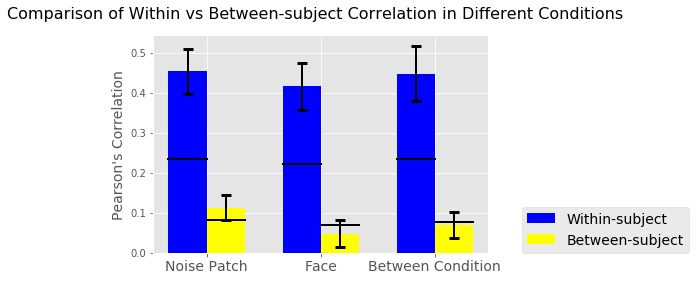

In [23]:
plt.style.use('ggplot')
x = ['Within-subject','Between-subject']
cond = ['Noise Patch','Face','Between Condition']
meanRs = [[meanBootWithinR[0],meanBootBtwR[0]],\
          [meanBootWithinR[1],meanBootBtwR[1]],\
          [meanBootWithinR[2],meanBootBtwR[2]]]
CIs = [np.array([[meanBootWithinR[0]-bootWithinCI[0][0],meanBootBtwR[0]-bootBtwCI[0][0]], \
               [bootWithinCI[0][1]-meanBootWithinR[0],bootBtwCI[0][1]-meanBootBtwR[0]]]),\
      np.array([[meanBootWithinR[1]-bootWithinCI[1][0],meanBootBtwR[1]-bootBtwCI[1][0]], \
               [bootWithinCI[1][1]-meanBootWithinR[1],bootBtwCI[1][1]-meanBootBtwR[1]]]),\
      np.array([[meanBootWithinR[2]-bootWithinCI[2][0],meanBootBtwR[2]-bootBtwCI[2][0]], \
               [bootWithinCI[2][1]-meanBootWithinR[2],bootBtwCI[2][1]-meanBootBtwR[2]]])]
barWidth = .2
x_cond = [barWidth*0.5,barWidth*3.5,barWidth*6.5]
x_pos=[[0,barWidth],[barWidth*3,barWidth*4],[barWidth*6,barWidth*7]]
p1=plt.bar(x_pos[0], meanRs[0], color=['blue','yellow'],yerr=CIs[0],\
        width=barWidth,error_kw=dict(lw=2, capsize=5, capthick=3))
p2=plt.bar(x_pos[1], meanRs[1], color=['blue','yellow'],yerr=CIs[1],\
        width=barWidth,error_kw=dict(lw=2, capsize=5, capthick=3))         
p3=plt.bar(x_pos[2], meanRs[2], color=['blue','yellow'],yerr=CIs[2],\
        width=barWidth,error_kw=dict(lw=2, capsize=5, capthick=3))
ii = 0
for bar_pos in x_pos:    
    plt.plot(np.array(bar_pos)-barWidth/2,\
             [permWithinCI[ii][1],permWithinCI[ii][1]],\
             color='black',linewidth=2)
    plt.plot(np.array(bar_pos)+barWidth/2,\
             [permBtwCI[ii][1],permBtwCI[ii][1]],\
             color='black',linewidth=2)
    ii += 1
plt.xticks(x_cond,cond,fontsize=14)
lgd=plt.legend(p1,x,loc=[1.1,0],fontsize=14)
# plt.errorbar([0,2*barWidth],[0,0],[[-permWithinCI[0],-permBtwCI[0]],\
#                                    [permWithinCI[1],permBtwCI[1]]],fmt='.k',\
#              capsize=40,ecolor='red')
plt.ylabel("Pearson's Correlation",fontsize=14)
ttl = plt.suptitle("Comparison of Within vs Between-subject Correlation in Different Conditions",fontsize=16)
if analysisInput == 2:
    plt.savefig("WithinBetweenCorrRT.png")
elif analysisInput == 1:
    plt.savefig("WithinBetweenCorr.png")
elif analysisInput == 3:
    plt.savefig("WithinBetweenCorrDI.png",bbox_extra_artists=(lgd,ttl), bbox_inches='tight')
else:
    plt.savefig("WithinBetweenCorrEccErrors.png",bbox_extra_artists=(lgd,ttl), bbox_inches='tight')
# # plot perm CIs as horizontal bars
# plt.plot([-barWidth/2,barWidth/2],[permWithinCI[0],permWithinCI[0]],color = 'red')
# plt.plot([-barWidth/2,barWidth/2],[permWithinCI[1],permWithinCI[1]],color = 'red')
# plt.plot([3*barWidth/2,5*barWidth/2],[permBtwCI[0],permBtwCI[0]],color = 'blue')
# plt.plot([3*barWidth/2,5*barWidth/2],[permBtwCI[1],permBtwCI[1]],color = 'blue')

# Magnitude of Errors in Different Conditions

## functions

In [57]:
def avgAcrossTrials(err,reps = 8,subjAll = subjs):
    avgErr = dict()
    for subj in subjAll:
        avgErr[subj] = err[subj].groupby('locs',as_index=False).errors.mean().errors
    return avgErr

def plotNbFace(face,nb,subjAll = subjs):
    fig, axs = plt.subplots(2, int(np.ceil(len(subjAll)/2)))
    itx = 0
    ity = 0
    num = 1
    for subj in subjAll:
        axs[itx,ity].scatter(nb[subj],face[subj])
        axs[itx,ity].plot(nb[subj],nb[subj],color='r')
        if num < np.ceil(len(subjAll)/2):
            ity += 1
            num += 1
        else:
            itx = 1
            ity = 0
            num = 1
    return None
       
def createDf(face,nb,DI = False,dataAll = dataAll,subjAll = subjs):
    df = pd.DataFrame()
    for subj in subjAll:
        toAdd = pd.DataFrame()
        if DI:
            toAdd['err'] = calSlope(face[subj],1).append(calSlope(nb[subj],1))
        else:
            toAdd['err'] = face[subj].append(nb[subj])
        toAdd['angles'] = np.vstack((np.arange(0,360,7.5).reshape(48,1),np.arange(0,360,7.5).reshape(48,1)))
        toAdd['subj'] = np.repeat(subj,96)
        toAdd['cond'] = np.vstack(((np.repeat('face',48)).reshape(48,1),(np.repeat('nb',48)).reshape(48,1)))
        toAdd['age'] = dataAll[subj].age
        toAdd['gender'] = dataAll[subj].gender
        toAdd['absErr'] = abs(toAdd['err'])
        df = df.append(toAdd)
    df.index = np.arange(df.shape[0])
    return df
    
def errDiff(face,nb,subjAll = subjs):
    df = pd.DataFrame()
    for subj in subjAll:
        toAdd = pd.DataFrame()
        toAdd['diff_val'] = avgNoise[subj] - avgFace[subj]
        toAdd['angles'] = np.arange(0,360,7.5)
        toAdd['subj'] = np.repeat(subj,48)
        df = df.append(toAdd)
    df.index = np.arange(df.shape[0])
    return df

## Construct DateFrame

In [58]:
DI = False
if analysisInput == 2:
    face = rtFace
    nb = rtNoise
elif analysisInput == 4:
    face = eccFace
    nb = eccNoise
else:
    face = errFace
    nb = errNoise  
if analysisInput == 3:
    DI = True
avgFace = avgAcrossTrials(face)
avgNoise = avgAcrossTrials(nb)    
df = createDf(avgFace,avgNoise,DI)
df['LoVF'] = df.angles<180
df['LeVF'] = (df.angles>90)&(df.angles<=270)
df['Horz'] = (df.angles<30)|((df.angles>=150)&(df.angles<210))|(df.angles>=330)
df['Vert'] = ((df.angles>=60)&(df.angles<120))|((df.angles>=240)&(df.angles<300))
df['Oblique'] = (~df['Horz'])&(~df['Vert'])
display(df.head(),avgFace['EW'])

,err,angles,subj,cond,age,gender,absErr,LoVF,LeVF,Horz,Vert,Oblique
0,-0.014119,0.0,EW,face,21,Male,0.014119,True,False,True,False,False
1,0.007053,7.5,EW,face,21,Male,0.007053,True,False,True,False,False
2,0.017304,15.0,EW,face,21,Male,0.017304,True,False,True,False,False
3,-0.010281,22.5,EW,face,21,Male,0.010281,True,False,True,False,False
4,0.009557,30.0,EW,face,21,Male,0.009557,True,False,False,False,True


0    -0.014119
1     0.007053
2     0.017304
3    -0.010281
4     0.009557
5    -0.009644
6    -0.006051
7    -0.008236
8    -0.028817
9     0.019893
10   -0.023628
11   -0.017707
12   -0.032312
13   -0.017074
14   -0.031281
15   -0.021983
16   -0.028825
17   -0.015624
18   -0.009385
19   -0.021353
20   -0.030545
21   -0.001427
22   -0.021559
23   -0.028186
24   -0.032352
25    0.008721
26   -0.005249
27   -0.012785
28    0.002488
29   -0.032034
30   -0.009137
31    0.001233
32   -0.009695
33   -0.006568
34   -0.016148
35   -0.024866
36   -0.024262
37   -0.016965
38   -0.020089
39    0.007472
40    0.011778
41    0.013834
42    0.007589
43    0.013980
44    0.013582
45    0.024462
46    0.002342
47    0.007945
Name: errors, dtype: float64

Ttest_relResult(statistic=-0.557687005325719, pvalue=0.5774305972804366)

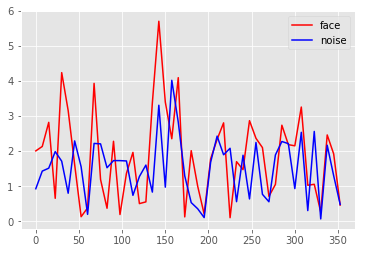

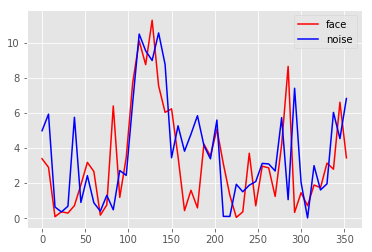

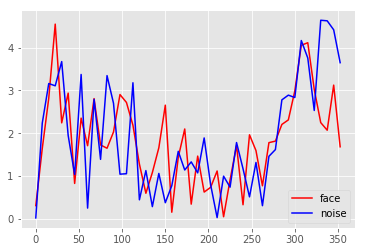

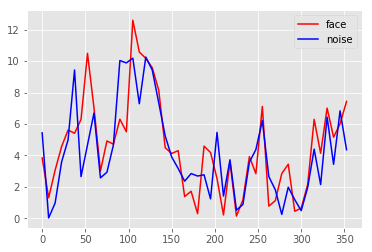

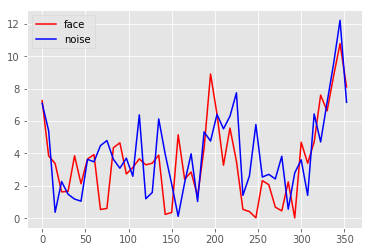

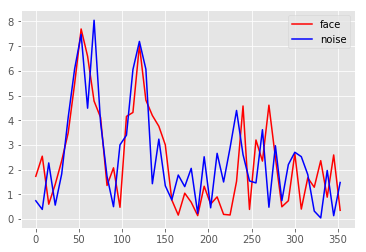

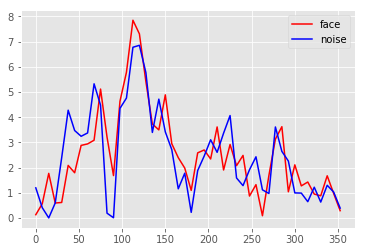

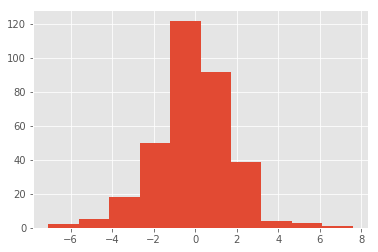

In [151]:
df4 = pd.DataFrame()
for ss in subjs:
    tmp_df = df[df.subj==ss].pivot_table(index="angles",columns="cond",values='absErr',aggfunc=np.mean)
    tmp_df['subj'] = ss
    plt.figure()
    plt.plot(tmp_df.index,tmp_df.face,c='red',label='face')
    plt.plot(tmp_df.index,tmp_df.nb,c='blue',label='noise')
    plt.legend()
#     plt.savefig("absEccErrorAcrossAngles_"+ss+".png")
    df4 = pd.concat([df4,tmp_df])
# sns.kdeplot(x=tmp_df['face'],y=tmp_df['nb'])
plt.figure()
plt.hist(df4['face']-df4['nb'])
plt.savefig("absEccErrorDifference.png")
ttest(np.array(df4['face']),np.array(df4['nb']))


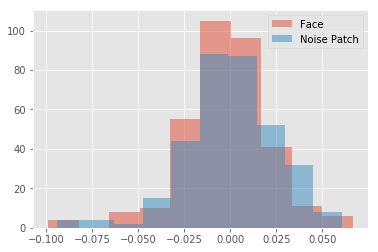

In [51]:
plt.hist(df.loc[df.cond=='face','err'],alpha=0.5,label="Face")
plt.hist(df.loc[df.cond=='nb','err'],alpha=0.5,label="Noise Patch")
plt.legend()
plt.savefig('eccerrorDistribution.png')

## Modeling in R

### Compare different conditions and individual diffs

In [59]:
%%R -i df
library(nlme)
library(car)
df$subj = factor(df$subj)
df$cond = factor(df$cond)
df$Horz = factor(df$Horz)
df$Vert = factor(df$Vert)
# df$gender = factor(df$gender)
# df$angles = factor(df$angles)
# model_lme <- lme(err~cond+(LoVF*Vert+LoVF*LeVF+LeVF*Horz),random = ~1|subj,data=df)
model_abs_lme <- lme(absErr~cond*(LoVF+LeVF),random = ~1|subj,data=df)
model_raw_lme <- lme(err~cond*(LoVF+LeVF),random = ~1|subj,data=df)
# model_lm <- lm(err~cond*(LoVF*Vert+LoVF*LeVF+LeVF*Horz),data=df)
# model_lm <- lm(err~cond,data=df)
model_null <- lm(err~1,data=df)
summary(model_raw_lme)
# summary(model_abs_lme)

# Anova(model_abs_lme)
# Anova(model_raw_lme)
# anova(model_lme,model_lm)

Linear mixed-effects model fit by REML
 Data: df 
        AIC       BIC   logLik
  -3271.106 -3235.095 1643.553

Random effects:
 Formula: ~1 | subj
        (Intercept)  Residual
StdDev:  0.01371104 0.0197195

Fixed effects: err ~ cond * (LoVF + LeVF) 
                       Value   Std.Error  DF   t-value p-value
(Intercept)     -0.005451103 0.005526160 660 -0.986418  0.3243
condnb           0.005787978 0.002713806 660  2.132790  0.0333
LoVFTRUE        -0.002605419 0.002159083 660 -1.206724  0.2280
LeVFTRUE         0.009573212 0.002159083 660  4.433925  0.0000
condnb:LoVFTRUE -0.006418612 0.003053405 660 -2.102116  0.0359
condnb:LeVFTRUE -0.000331107 0.003053405 660 -0.108439  0.9137
 Correlation: 
                (Intr) condnb LoVFTRUE LeVFTRUE condnb:LoVFTRUE
condnb          -0.246                                         
LoVFTRUE        -0.212  0.431                                  
LeVFTRUE        -0.212  0.431  0.083                           
condnb:LoVFTRUE  0.150 -0.609 -0.70

### Visualize the comparisons

In [32]:
def boot_ci(data,errType,ci=95,iters=1000):
    allMean = []
    realMean = np.mean(data[errType])
    for i in range(iters):
        randMean = []
        for subj in data.subj.unique():
            randMean.append(np.mean(np.random.choice(data.loc[data.subj==subj,errType],len(data.subj),replace=True)))
        allMean.append(np.mean(randMean))
    allMean = np.sort(np.array(allMean))
    return np.array([realMean-allMean[int(iters*((100-ci)/200))],allMean[int(iters*((100+ci)/200))]-realMean])

In [34]:
# Dataframe for plotting
plotdf=df.copy()
plotdf.loc[(plotdf.LoVF)&(plotdf.LeVF),'quad'] = 'LoLe'
plotdf.loc[(plotdf.LoVF)&(~plotdf.LeVF),'quad'] = 'LoRi'
plotdf.loc[(~plotdf.LoVF)&(plotdf.LeVF),'quad'] = 'UpLe'
plotdf.loc[(~plotdf.LoVF)&(~plotdf.LeVF),'quad'] = 'UpRi'

# within-subject error bar estimation
# # first, center the data
# aggTable = plotdf.groupby(by=["cond","quad","subj"],as_index=False).err.mean()
# aggTableCopy = aggTable.copy()
# for subj in aggTable.subj.unique():
#     aggTable.loc[aggTable.subj == subj,"err"] = \
#     aggTable.loc[aggTable.subj == subj,"err"] - np.mean(aggTable.loc[aggTable.subj == subj,"err"])
# aggTable.loc[:,"err"] = aggTable.loc[:,"err"]+np.mean(aggTableCopy.err)
# # then, incorporate the correction factor
# aggTableCopy = aggTable.copy()
# cf = np.sqrt(2*2*2/2*2*2-1)
# for cond in aggTable.cond.unique():
#     for quad in aggTable.quad.unique():
#         condMean = np.mean(aggTable.loc[(aggTable.cond == cond)&(aggTable.quad == quad),"err"])
#         aggTable.loc[(aggTable.cond == cond)&(aggTable.quad == quad),"err"] = \
#         cf*(aggTable.loc[(aggTable.cond == cond)&(aggTable.quad == quad),"err"] - condMean) + condMean
# # finally, calculate the standard error
errBarRaw = pd.DataFrame()
errBarAbs = pd.DataFrame()
for cond in  plotdf.cond.unique():
    for quad in plotdf.quad.unique():
        d = plotdf.loc[(plotdf.cond==cond)&(plotdf.quad==quad)]
        errBarRaw[cond+quad] = boot_ci(d,"err")
        errBarAbs[cond+quad] = boot_ci(d,"absErr")
# errBarAbs = plotdf.groupby(by=["cond","quad","subj"],as_index=False).absErr.mean().\
# groupby(by=["cond","quad"],as_index=False).agg({"absErr":np.std})
# errBarAbs["absErr"] = errBarAbs.absErr/np.sqrt(7)


# plot options
if analysisInput == 4:
    errType = "Eccentricity"
elif analysisInput == 1:
    errType = "Angular"
else:
    errType= "rt_"

In [35]:
# plotdf.head()
# boot_ci(plotdf[plotdf.quad=="LoLe"],"err")
# errBarRaw.head()
errBarRaw = np.array(errBarRaw)
errBarAbs = np.array(errBarAbs)

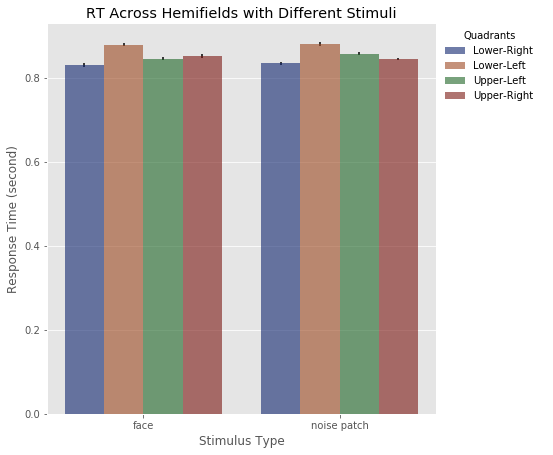

In [39]:
plt.style.use('ggplot')
# Raw Errors Plot
g = sns.catplot(
    data=plotdf, kind="bar",
    x="cond", y="err", hue="quad",
    palette="dark", alpha=.6, height=6,
    legend_out = True, ci=None
)
xl=plt.xlabel("Stimulus Type")
plt.xticks(ticks=[0,1],labels=["face","noise patch"])
if analysisInput == 2:
    plt.ylabel("Response Time (second)")
    ttl=plt.title("RT Across Hemifields with Different Stimuli")
else:
    plt.ylabel(errType+" Errors")
    ttl=plt.title(errType+" Errors Across Hemifields with Different Stimuli")
# title
new_title = 'Quadrants'
g._legend.set_title(new_title)
g._legend.set_bbox_to_anchor([1.1,0.9])
# replace labels
new_labels = ["Lower-Right","Lower-Left","Upper-Left","Upper-Right"]
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# plot customized error bars
x_coords = np.hstack((np.arange(-0.3,0.5,0.2),np.arange(0.7,1.5,0.2)))
y_coords = []
uniqQuad = plotdf.quad.unique()
uniqCond = plotdf.cond.unique()
for cond in uniqCond:
    for quad in uniqQuad:
        y_coords.append(np.mean(plotdf.loc[(plotdf.cond==cond)&(plotdf.quad==quad),"err"]))
plt.errorbar(x_coords,y_coords, yerr=errBarRaw,c="black",fmt=' ', zorder=-1)
# save figure
g.savefig(errType[:3]+"ErrorAcrossHemifields.png",bbox_extra_artists=(xl,ttl))

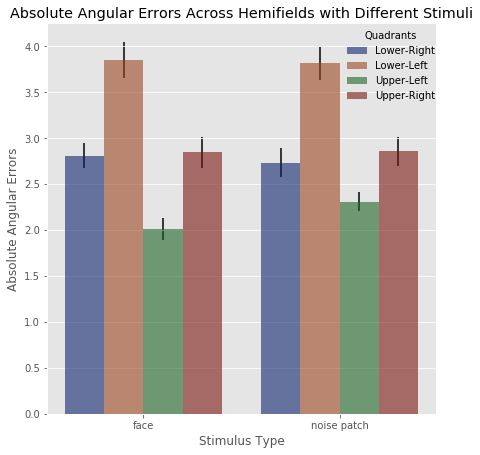

In [26]:
# Absolute errors
# upper vs lower hemifield
g = sns.catplot(
    data=plotdf, kind="bar",
    x="cond", y="absErr", hue="quad",
    palette="dark", alpha=.6, height=6,
    legend_out = True, ci= None
)
xl=plt.xlabel("Stimulus Type")
plt.xticks(ticks=[0,1],labels=["face","noise patch"])

plt.ylabel("Absolute " + errType + " Errors")
ttl=plt.title("Absolute "+ errType + " Errors Across Hemifields with Different Stimuli")
# title
new_title = 'Quadrants'
g._legend.set_title(new_title)
g._legend.set_bbox_to_anchor([0.9,0.9])
# replace labels
new_labels = ["Lower-Right","Lower-Left","Upper-Left","Upper-Right"]
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# plot customized error bars
x_coords = np.hstack((np.arange(-0.3,0.5,0.2),np.arange(0.7,1.5,0.2)))
y_coords = []
uniqQuad = plotdf.quad.unique()
uniqCond = plotdf.cond.unique()
for cond in uniqCond:
    for quad in uniqQuad:
        y_coords.append(np.mean(plotdf.loc[(plotdf.cond==cond)&(plotdf.quad==quad),"absErr"]))
plt.errorbar(x_coords,y_coords, yerr=errBarAbs,c="black",fmt=' ', zorder=-1)
# save fig
plt.savefig("abs"+errType[:3]+"ErrorAcrossHemifields.png",bbox_extra_artists=(xl,ttl), bbox_inches='tight')

## Plot in ggplot2

R[write to console]: Saving 6.67 x 6.67 in image



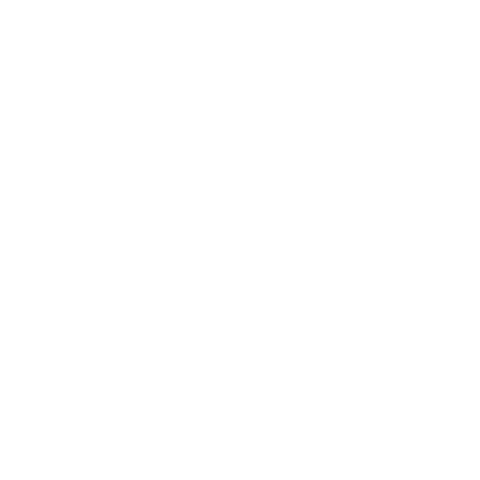

In [85]:
%%R -i df
library(ggplot2)
library(gridExtra)
subjs = unique(df$subj)
for (ss in subjs) {
    df_face = (df[df$subj == ss,])[0:48,]
    df_nb = (df[df$subj == ss,])[48:96,]
    # faces
    p1 = ggplot(df_face, aes(x=angles,y=2, fill=err)) +
    geom_tile() +
    ylim(c(1,3)) +
    theme(panel.background = element_rect(fill = 'white'),
         legend.position = 'none') +
    scale_colour_gradient2(low = "blue", mid = "white",midpoint=mean(0.55),
                         high ="red",space = "Lab",
                         guide = guide_colourbar(direction = "horizontal"), 
                         aesthetics = "fill",limits = c(0.47,0.62)) +  
    coord_polar(start=pi/2, direction=1)
    # noise blob
    p2 = ggplot(df_nb, aes(x=angles,y=2, fill=err)) + 
    geom_tile() +
    ylim(c(1,3)) +
    theme(panel.background = element_rect(fill = 'white'),
         legend.position = 'none') +
    scale_colour_gradient2(low = "blue", mid = "white",midpoint=mean(0.55),
                         high ="red",space = "Lab",
                         guide = guide_colourbar(direction = "horizontal"), 
                         aesthetics = "fill",limits = c(0.47,0.62)) +  
    coord_polar(start=pi/2, direction=1)
    f <- arrangeGrob(p1, p2, nrow = 1)
    # save fig
    if (ss=='EW') {
        ggsave(paste(ss,"_rt.png",sep=""),f)
    }
    
}

In [171]:
display(df.groupby(by=['LoVF','LeVF']).err.mean(),\
       df.groupby(by=['Horz','LeVF']).err.mean(),\
       df.groupby(by=['Vert','LoVF']).err.mean())

LoVF   LeVF 
False  False   -0.188455
       True    -0.111161
True   False    0.341049
       True    -0.083231
Name: err, dtype: float64

Horz   LeVF 
False  False   -0.006212
       True    -0.097554
True   False    0.307503
       True    -0.099971
Name: err, dtype: float64

Vert   LoVF 
False  False   -0.200862
       True    -0.073716
True   False   -0.038038
       True     0.587194
Name: err, dtype: float64

# Unique Variance Analysis

## Preparation

In [445]:
DI = False
if analysisInput == 2:
    data5 = rtAll
elif analysisInput == 4:
    data5 = eccAll
else:
    data5 = errAll
if analysisInput == 3:
    DI = True

# df for analysis 5
df5 = pd.DataFrame()
for subjName in subjs:
    tmp = pd.DataFrame()
    self_nb = avgHalf(data5.loc[(data5.subj==subjName)&(data5.stim),:].\
                      sort_values('locs').reset_index(drop=True),genRandInd())
    self_face = avgHalf(data5.loc[(data5.subj==subjName)&(~(data5.stim)),:].\
                      sort_values('locs').reset_index(drop=True),genRandInd())
    other_nb = avgHalf(data5.loc[(~(data5.subj==subjName))&(data5.stim),:].\
                    sort_values('locs').reset_index(drop=True),genRandInd(subjNum=len(subjs)-1))
    other_face = avgHalf(data5.loc[(~(data5.subj==subjName))&(~(data5.stim)),:].\
                    sort_values('locs').reset_index(drop=True),genRandInd(subjNum=len(subjs)-1))
    if DI:
        tmp['err'] = calSlope(self_nb.half1)
        tmp['selfNB'] = calSlope(self_nb.half2)
        tmp['selfFace'] = calSlope(self_face.half1)
        tmp['otherNB'] = calSlope(other_nb.half1)
        tmp['otherFace'] = calSlope(other_face.half1)
    else:
        tmp['err'] = self_nb.half1
        tmp['selfNB'] = self_nb.half2
        tmp['selfFace'] = self_face.half1
        tmp['otherNB'] = other_nb.half1
        tmp['otherFace'] = other_face.half1
    tmp['subj'] = subjName
    df5 = pd.concat([df5,tmp])
df5=df5.reset_index(drop=True)

In [446]:
df5.tail()

,err,selfNB,selfFace,otherNB,otherFace,subj
331,-0.466557,-0.475366,-0.164603,-0.793104,-0.958261,KH
332,-0.233208,-0.165749,-0.170304,-0.103909,-0.095841,KH
333,-0.533104,-0.093355,0.024503,-0.302229,0.141543,KH
334,-0.138640,-0.165537,-0.280709,0.481371,0.246267,KH
335,0.266449,0.081425,-0.077160,0.458622,0.622407,KH


## Model

In [448]:
%%R -i df5
library(nlme)
library(ggplot2)
# first construct different models
mdl5_full <- lm(err~selfNB+selfFace+otherNB+otherFace,data=df5)
mdl5_noNB <- lm(err~selfFace+otherNB+otherFace,data=df5)
mdl5_noFace <- lm(err~selfNB+otherNB+otherFace,data=df5)
mdl5_noMeanNb <- lm(err~selfNB+selfFace+otherFace,data=df5)
mdl5_noMeanFace <- lm(err~selfNB+selfFace+otherNB,data=df5)
mdl5_null <- lm(err~1,data=df5)

# now calculate the unique variance
uniq_Nb <- (summary(mdl5_full)$r.squared - summary(mdl5_noNB)$r.squared)
uniq_face <- (summary(mdl5_full)$r.squared - summary(mdl5_noFace)$r.squared)
uniq_meanNb <- (summary(mdl5_full)$r.squared - summary(mdl5_noMeanNb)$r.squared)
uniq_meanFace <- (summary(mdl5_full)$r.squared - summary(mdl5_noMeanFace)$r.squared)
unexp <- 1 - summary(mdl5_full)$r.squared
shared <- 1 - uniq_face - uniq_meanNb - uniq_meanFace - unexp
# plot the unique variance percentage
data <- data.frame(
  x=c("selfNb","selfFace","meanNb","meanFace","shared","unexplained") ,  
  y=c(uniq_Nb,uniq_face,uniq_meanNb,uniq_meanFace,shared,unexp)
  )
ggplot(data,aes(x=x, y=y))+
 geom_bar(stat = "identity")
# print(uniq_face)
# print(uniq_meanNb)
# print(uniq_meanFace)
summary(mdl5_full)


Call:
lm(formula = err ~ selfNB + selfFace + otherNB + otherFace, data = df5)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.95612 -0.30553 -0.00636  0.30453  1.88337 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.024e-17  2.797e-02   0.000    1.000    
selfNB      3.994e-01  5.603e-02   7.128 6.41e-12 ***
selfFace    4.256e-01  5.516e-02   7.715 1.44e-13 ***
otherNB     1.446e-01  1.153e-01   1.254    0.211    
otherFace   8.875e-02  1.071e-01   0.828    0.408    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5127 on 331 degrees of freedom
Multiple R-squared:  0.5839,	Adjusted R-squared:  0.5789 
F-statistic: 116.1 on 4 and 331 DF,  p-value: < 2.2e-16



# Serial Dependence

## Preparation

In [249]:
# first decide which data to use; it does no make sense to analyze distortion indices for SD
if analysisInput == 1 or analysisInput == 3:
    data6 = errAll
elif analysisInput == 2:
    data6 = rtAll
else:
    data6 = eccAll

# Now construct the dataframe
df6 = pd.DataFrame()
df6_sc = pd.DataFrame()
for subj in subjs:
    tmp2 = pd.DataFrame()
    tmp3 = pd.DataFrame()
    tmp1 = data6.loc[data6.subj==subj,:].reset_index(drop=True)
    tmp1.loc[~tmp1.stim,'locs'] = tmp1.loc[~tmp1.stim,'locs'] - 48
    # n-1 trials
    tmp2['errors'] = np.array(tmp1.iloc[1:-1,0]) 
    tmp2['prevErr'] = np.array(tmp1.iloc[:-2,0])
    tmp2['prevLoc'] = np.array(tmp1.iloc[:-2,1])
    tmp2['currLoc'] = np.array(tmp1.iloc[1:-1,1])
    tmp2['prevStim'] = list(tmp1.iloc[:-2,2])
    tmp2['currStim'] = list(tmp1.iloc[1:-1,2])
    tmp2['rt'] = np.array(rtAll[rtAll.subj==subj].reset_index(drop=True).iloc[1:-1,0])
    tmp2['angdiff'] = 7.5*recenter(np.array(tmp1.iloc[:-2,1])-np.array(tmp1.iloc[1:-1,1])) #prev-curr
    tmp2['perceived_angdiff'] = 7.5*recenter(np.array(tmp1.iloc[:-2,1]) \
    - np.array(tmp1.iloc[1:-1,1])) + tmp2['prevErr'] #prev perceived loc - curr loc
    tmp2['stimdiff'] = tmp2['prevStim']==tmp2['currStim']
    tmp2['subj'] = subj
    tmp2 = polyCorrection(tmp2)
    df6 = pd.concat([df6,tmp2])
    # n+1 trials, sanity check
    tmp3['errors'] = np.array(tmp1.iloc[1:-1,0]) 
    tmp3['futErr'] = np.array(tmp1.iloc[2:,0])
    tmp3['futLoc'] = np.array(tmp1.iloc[2:,1])
    tmp3['currLoc'] = np.array(tmp1.iloc[1:-1,1])
    tmp3['futStim'] = list(tmp1.iloc[2:,2])
    tmp3['currStim'] = list(tmp1.iloc[1:-1,2])
    tmp3['angdiff'] = recenter(np.array(tmp1.iloc[2:,1])-np.array(tmp1.iloc[1:-1,1]))#future-curr
    tmp3['subj'] = subj
    df6_sc = pd.concat([df6_sc,tmp3])
    # update index
    df6.index = range(df6.shape[0])
    df6_sc.index = range(df6_sc.shape[0])
df6 = polyCorrection(df6,outCol='correctedGroupError')

In [250]:
df6.head()

,errors,prevErr,prevLoc,currLoc,prevStim,currStim,rt,angdiff,perceived_angdiff,stimdiff,subj,correctedError,correctedGroupError
0,-0.395137,-5.060612,33.0,18.0,False,True,0.699430,112.5,107.439388,False,EW,1.166623,-4.157850
1,0.101098,-0.395137,18.0,26.0,True,False,0.783045,-60.0,-60.395137,False,EW,-0.200800,-1.005176
2,-2.853664,0.101098,26.0,25.0,False,False,0.700115,7.5,7.601098,True,EW,-2.763131,-4.016874
3,-1.224130,-2.853664,25.0,10.0,False,True,0.798745,112.5,109.646336,False,EW,-1.315586,-1.931107
4,5.194429,-1.224130,10.0,6.0,True,True,0.799395,30.0,28.775870,True,EW,4.842738,6.040931


## Utils for VonMise

In [251]:
# Some global variables
bootA = []
permA = []
# functions
def vonmise_derivative(xdata, a, kai):
    xdata = xdata / 180 * np.pi
    return - a / (i0(kai) * 2 * np.pi) * np.exp(kai * np.cos(xdata)) * kai * np.sin(xdata) # Derivative of vonmise formula

def getRegressionLine(x, y, peak):
    stimuli_diff_filtered = []
    filtered_responseError_new = []
    for i in range(len(x)):
        if x[i] < peak + 1 and x[i] > - peak + 1:
            stimuli_diff_filtered.append(x[i])
            filtered_responseError_new.append(y[i])
    coef = np.polyfit(stimuli_diff_filtered,filtered_responseError_new,1)
    poly1d_fn = np.poly1d(coef)
    return poly1d_fn, coef

def polyFunc(x, coeffs):
    y = 0
    order = len(coeffs)
    for i in range(order):
        y += coeffs[i] * (x ** (order - 1 - i))
    return y

def polyCorrection(df,errCol='errors',outCol='correctedError'):
    coefs = np.polyfit(df['currLoc'], df[errCol],10) # polynomial coefs
    df[outCol] = [y - polyFunc(x, coefs) for x,y in zip(df['currLoc'], df[errCol])]
    temp_error = df[outCol].copy()
    df[outCol] = recenter(temp_error)
    return df

def CurvefitFunc(x, y, func=vonmise_derivative, init_vals=[-30, 3], bounds_input = ([-60,0.5],[60, 20])):
    best_vals, covar = curve_fit(func, x, y, p0=init_vals, bounds = bounds_input)
    return best_vals

def VonMise_fitting(x, y, x_range, boot=False,perm=False,func=vonmise_derivative, init_vals=[-30, 3],  bounds_input = ([-60,0.5],[60,20])):
    best_vals = CurvefitFunc(x, y, init_vals=init_vals, bounds_input = bounds_input)

    if boot:
        OutA = [] # Output a array, store each trial's a
        outSlope = []
        outIntercept = []
        bsSize = int(1.0 * len(x))
        bootiter=1000
        for i in range(bootiter):
            RandIndex = np.random.choice(len(x), bsSize, replace=True) # get randi index of xdata
            xdataNEW = [x[j] for j in RandIndex] # change xdata index
            ydataNEW = [y[j] for j in RandIndex] # change ydata index
            try:
                temp_best_vals = CurvefitFunc(xdataNEW, ydataNEW, init_vals=init_vals, bounds_input=bounds_input)
                new_x = np.linspace(-x_range, x_range, 300)
                new_y = [vonmise_derivative(xi,temp_best_vals[0],temp_best_vals[1]) for xi in new_x]
                if new_x[np.argmax(new_y)] > 0: 
                    OutA.append(np.max(new_y))
                else: 
                    OutA.append(-np.max(new_y))

#                 poly1d_fn, coef = getRegressionLine(xdataNEW, ydataNEW, self.peak_x)
#                 outSlope.append(coef[0])
#                 outIntercept.append(coef[1])
            except RuntimeError:
                pass
        print("bs_a:",round(np.mean(OutA),2),"	95% CI:",np.percentile(OutA,[2.5,97.5]))
#         bootA = OutA  ###ADD ME BACK YO
#         self.outSlope = outSlope
#         self.outIntercept = outIntercept
        # np.save(self.result_folder + 'bootstrap.npy', OutA)

    if perm:
        # perm_a, perm_b = repeate_sampling('perm', xdata, ydata, CurvefitFunc, size = permSize)
        OutB = [] # Output a array, store each trial's a
        perm_xdata = x
        permIter = 1000
        for i in range(permIter):
            perm_xdata = np.random.permutation(perm_xdata) # permutate nonlocal xdata to update, don't change ydata
            try:
                temp_best_vals = CurvefitFunc(perm_xdata, y, init_vals=init_vals, bounds_input=bounds_input) # permutation make a sample * range(size) times
                new_x = np.linspace(-x_range, x_range, 300)
                new_y = [vonmise_derivative(xi,temp_best_vals[0],temp_best_vals[1]) for xi in new_x]
                if new_x[np.argmax(new_y)] > 0: 
                    OutB.append(np.max(new_y))
                else: 
                    OutB.append(-np.max(new_y))
            except RuntimeError:
                pass
        print("perm_a:",round(np.mean(OutB),2),"	95% CI:",np.percentile(OutB,[5,95]))
        
    print('Von Mise Parameters: amplitude {0:.4f}, Kai {1:.4f}.'.format(best_vals[0],best_vals[1]))
    return best_vals#, outSlope, outIntercept
    #return OutA ###TAKE OUT OUTA YO
    

In [271]:
best_vals_face = dict()
best_vals_nb = dict()
condi='prevStim'
val='angdiff'
for ss in subjs:
    best_vals_face[ss]=VonMise_fitting(np.array(df6.loc[(df6.subj==ss)&(~df6[condi]),val]),\
                                  np.array(df6[(df6.subj==ss)&(~df6[condi])]['correctedError']),180)
    best_vals_nb[ss]=VonMise_fitting(np.array(df6.loc[(df6.subj==ss)&(df6[condi]),val]),\
                                  np.array(df6[(df6.subj==ss)&(df6[condi])]['correctedError']),180)


best_vals_group_nb=VonMise_fitting(np.array(df6[df6[condi]][val]),\
                                   np.array(df6[df6[condi]]['correctedGroupError']),180)
best_vals_group_face=VonMise_fitting(np.array(df6[~df6[condi]][val]),\
                                     np.array(df6[~df6[condi]]['correctedGroupError']),180)



Von Mise Parameters: amplitude -4.5382, Kai 0.5000.
Von Mise Parameters: amplitude -7.1002, Kai 0.5000.
Von Mise Parameters: amplitude -0.5822, Kai 20.0000.
Von Mise Parameters: amplitude -0.3778, Kai 15.1540.
Von Mise Parameters: amplitude -0.2214, Kai 15.2553.
Von Mise Parameters: amplitude -0.2179, Kai 20.0000.
Von Mise Parameters: amplitude -6.2970, Kai 0.5000.
Von Mise Parameters: amplitude -0.7991, Kai 0.9522.
Von Mise Parameters: amplitude -0.5719, Kai 6.3416.
Von Mise Parameters: amplitude -0.6327, Kai 8.9757.
Von Mise Parameters: amplitude 2.4252, Kai 1.5770.
Von Mise Parameters: amplitude 1.7422, Kai 3.5803.
Von Mise Parameters: amplitude -0.5315, Kai 3.2650.
Von Mise Parameters: amplitude -0.5679, Kai 6.3000.
Von Mise Parameters: amplitude -0.1372, Kai 20.0000.
Von Mise Parameters: amplitude -0.1107, Kai 13.0887.


## Visualize Raw Data

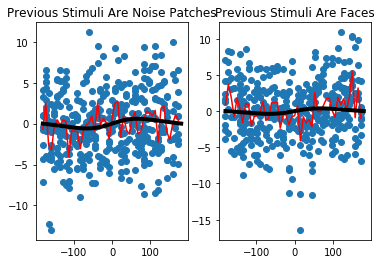

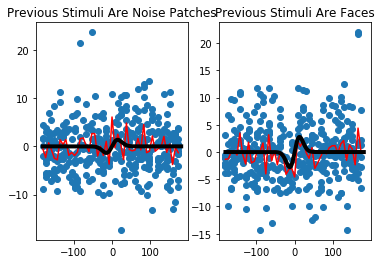

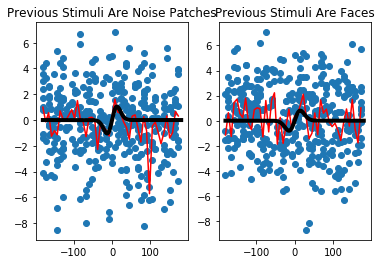

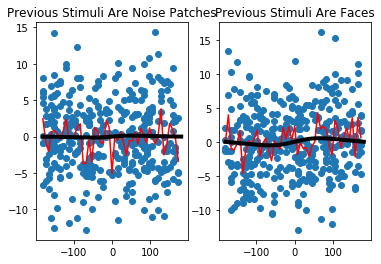

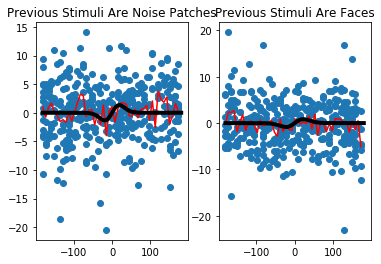

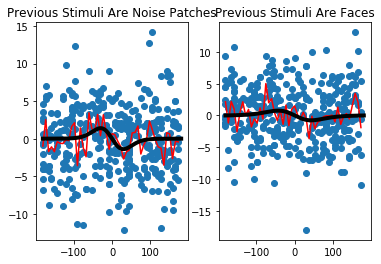

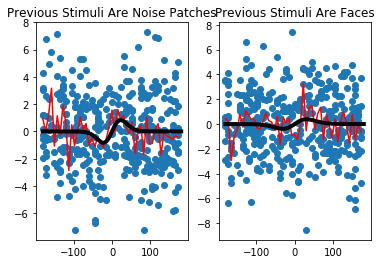

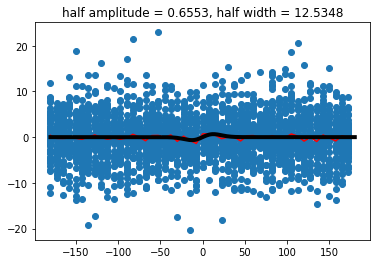

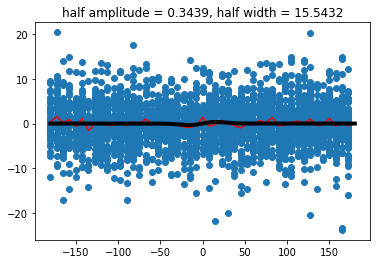

In [273]:
# display(df.head(),data6['EW'].head()
# display(df.head(),df_sc.head(),data6['EW'].head(),data6['EW'].iloc[1:-1,0])
df6['rounded'] = df6['perceived_angdiff'].round()
condi = 'prevStim'
val='angdiff'
amp_nb=list()
amp_face=list()
for ss in subjs:
    plt.figure()
    ax=plt.subplot(1,2,1)
    plt.scatter(x=df6.loc[(df6.subj==ss)&(df6[condi]),val],\
            y=df6.loc[(df6.subj==ss)&(df6[condi]),'correctedError'])
    running_mean = df6.loc[(df6.subj==ss)&(df6[condi]),:].groupby(by=val).correctedError.mean()
    plt.plot(running_mean,color='red')
    # plot von mises fit
    x_range = 180
    new_x = np.linspace(-x_range, x_range, 360)
    new_y = [vonmise_derivative(xi,best_vals_nb[ss][0],best_vals_nb[ss][1]) for xi in new_x]
    if new_x[np.argmax(new_y)] > 0: 
        amp_nb.append(np.max(new_y))
    else: 
        amp_nb.append(-np.max(new_y))
    plt.plot(new_x, new_y, 'k-', linewidth = 4)
    ax.set_title("Previous Stimuli Are Noise Patches")
    
    
    ax=plt.subplot(1,2,2)
    plt.scatter(x=df6.loc[(df6.subj==ss)&(~df6[condi]),val],\
            y=df6.loc[(df6.subj==ss)&(~df6[condi]),'correctedError'])
#     plt.xlim([-5,5])
#     plt.ylim([-10,10])
    running_mean = df6.loc[(df6.subj==ss)&(~df6[condi]),:].groupby(by=val).correctedError.mean()
    plt.plot(running_mean,color='red')
    # plot von mises fit
    x_range = 180
    new_x = np.linspace(-x_range, x_range, 360)
    new_y = [vonmise_derivative(xi,best_vals_face[ss][0],best_vals_face[ss][1]) for xi in new_x]
    second_x = np.linspace(-x_range, x_range, 360)
    DoVM_values = [vonmise_derivative(xi,best_vals_face[ss][0],best_vals_face[ss][1]) for xi in second_x]
    plt.plot(new_x, new_y, 'k-', linewidth = 4)
    if new_x[np.argmax(new_y)] > 0: 
        amp_face.append(np.max(new_y))
    else: 
        amp_face.append(-np.max(new_y))
    ax.set_title("Previous Stimuli Are Faces")
    plt.savefig(ss+"_prevStim"+".png")
#     plt.scatter(x=df.loc[(df.subj==ss)&(df.prevStim==df.currStim),'prevErr'],\
#                 y=df.loc[(df.subj==ss)&(df.prevStim==df.currStim),'errors'])
#     plt.scatter(x=df.loc[(df.subj==ss)&(~df.prevStim==df.currStim),'prevErr'],\
#                 y=df.loc[(df.subj==ss)&(~df.prevStim==df.currStim),'errors'],c='green')
#     running_mean_same = df.loc[(df.subj==ss)&(df.prevStim==df.currStim),:].groupby(by='prevErr').errors.mean()
#     running_mean_diff = df.loc[(df.subj==ss)&(~df.prevStim==df.currStim),:].groupby(by='prevErr').errors.mean()
#     plt.plot(running_mean_same,color='red')
#     plt.plot(running_mean_diff,color='orange')

# Plot Group Result
plt.figure()
plt.scatter(x=df6.loc[df6[condi],val],\
            y=df6.loc[df6[condi],'correctedGroupError'])
running_mean = df6[df6[condi]].groupby(by=val).correctedGroupError.mean()
plt.plot(running_mean,color='red')
x_range = 180
new_x = np.linspace(-x_range, x_range, 360)
new_y = [vonmise_derivative(xi,best_vals_group_nb[0],best_vals_group_nb[1]) for xi in new_x]
second_x = np.linspace(-x_range, x_range, 360)
DoVM_values = [vonmise_derivative(xi,best_vals_group_nb[0],best_vals_group_nb[1]) for xi in second_x]
plt.plot(new_x, new_y, 'k-', linewidth = 4)
if new_x[np.argmax(new_y)] > 0:
    plt.title("half amplitude = {0:.4f}, half width = {1:.4f}". format(np.max(new_y), new_x[np.argmax(new_y)]))
else: 
    plt.title("half amplitude = {0:.4f}, half width = {1:.4f}". format(-np.max(new_y), -new_x[np.argmax(new_y)]))
plt.savefig("group_prevStim_nb.png")
# Plot Group Result - PrevStim Face
plt.figure()
plt.scatter(x=df6.loc[~df6[condi],val],\
            y=df6.loc[~df6[condi],'correctedGroupError'])
running_mean = df6[~df6[condi]].groupby(by=val).correctedGroupError.mean()
plt.plot(running_mean,color='red')
x_range = 180
new_x = np.linspace(-x_range, x_range, 360)
new_y = [vonmise_derivative(xi,best_vals_group_face[0],best_vals_group_face[1]) for xi in new_x]
second_x = np.linspace(-x_range, x_range, 360)
DoVM_values = [vonmise_derivative(xi,best_vals_group_face[0],best_vals_group_face[1]) for xi in second_x]
plt.plot(new_x, new_y, 'k-', linewidth = 4)
if new_x[np.argmax(new_y)] > 0:
    plt.title("half amplitude = {0:.4f}, half width = {1:.4f}". format(np.max(new_y), new_x[np.argmax(new_y)]))
else: 
    plt.title("half amplitude = {0:.4f}, half width = {1:.4f}". format(-np.max(new_y), -new_x[np.argmax(new_y)]))
plt.savefig("group_prevStim_face.png")
# plt.scatter(x=df.loc[(~df.prevStim),'prevErr'],\
#             y=df.loc[(~df.prevStim),'errors'],c='green')
# running_mean_same = df.loc[(df.prevStim==df.currStim),:].groupby(by='prevErr').errors.mean()
# running_mean_diff = df.loc[(~df.prevStim==df.currStim),:].groupby(by='prevErr').errors.mean()
# # plt.plot(running_mean_same,color='red')
# # plt.plot(running_mean_diff,color='orange')
# plt.figure()
# plt.plot(x=np.array(circ_moving_average(running_mean_diff.index,circ=False)),\
#          y=np.array(circ_moving_average(running_mean_diff,circ=False)))
# plt.xlim([-20,20])
# plt.ylim([-20,20])
# plt.xlim([-5,5])
# plt.ylim([-20,20])

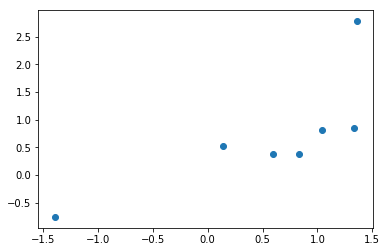

In [275]:
plt.scatter(x=amp_nb,y=amp_face)

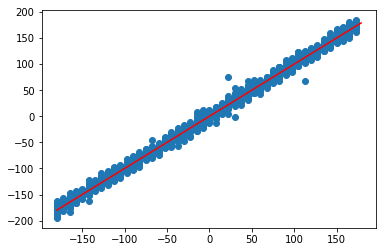

In [224]:
plt.scatter(df6[~df6.prevStim]['angdiff'],df6[~df6.prevStim]['perceived_angdiff'])
plt.plot(np.arange(-180,180),np.arange(-180,180),c='red')

## Modeling in R

In [246]:
%%R -i df6
library(nlme)
# df$angles = factor(df$angles)
model_lm <- lm(correctedError~(angdiff+perceived_angdiff)*(prevStim*stimdiff),data=df6)
print("Full Model")
print(summary(model_lm))
dataPrevNoise = subset(df6, prevStim == TRUE)
dataPrevFace = subset(df6, prevStim == FALSE)
mdl_noise <- lm(correctedError~perceived_angdiff+angdiff,data=dataPrevNoise)
mdl_face <- lm(correctedError~perceived_angdiff+angdiff,data=dataPrevFace)
print("Model: Previous Stimuli Are NP")
print(summary(mdl_noise))
print("Model: Previous Stimuli Are FACES")
print(summary(mdl_face))

[1] "Full Model"

Call:
lm(formula = correctedError ~ (angdiff + perceived_angdiff) * 
    (prevStim * stimdiff), data = df6)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.116855 -0.022051 -0.001313  0.020154  0.149438 

Coefficients:
                                              Estimate Std. Error t value
(Intercept)                                  0.0008229  0.0009375   0.878
angdiff                                     -0.1100769  0.0226289  -4.864
perceived_angdiff                            0.1100711  0.0226287   4.864
prevStimTRUE                                -0.0018408  0.0013257  -1.389
stimdiffTRUE                                -0.0017507  0.0013362  -1.310
prevStimTRUE:stimdiffTRUE                    0.0043203  0.0018888   2.287
angdiff:prevStimTRUE                         0.0151908  0.0325187   0.467
angdiff:stimdiffTRUE                        -0.0411643  0.0328598  -1.253
perceived_angdiff:prevStimTRUE              -0.0152113  0.0325185  -0.468
perce

Noise: prevErr     b = -0.04, p = .059 <br>
Face:  prevErr     b = 0.08,  p < .001 <br>

In [212]:
%%R -i df_sc
model_lm <- lm(errors~(futErr+angdiff)*futStim,data=df_sc)
# dataPrevNoise = subset(df_sc, prevStim == TRUE)
# dataPrevFace = subset(df_sc, prevStim == FALSE)
# mdl_noise <- lm(errors~prevErr+angdiff,data=dataPrevNoise)
# mdl_face <- lm(errors~prevErr+angdiff,data=dataPrevFace)
summary(model_lm)


Call:
lm(formula = errors ~ (futErr + angdiff) * futStim, data = df_sc)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.578  -3.192  -0.010   3.095  53.306 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.566461   0.105194   5.385 7.56e-08 ***
futErr               0.019946   0.019283   1.034    0.301    
angdiff              0.031907   0.005350   5.964 2.62e-09 ***
futStimTRUE         -0.089068   0.148620  -0.599    0.549    
futErr:futStimTRUE   0.000956   0.027221   0.035    0.972    
angdiff:futStimTRUE  0.008105   0.007554   1.073    0.283    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.415 on 5356 degrees of freedom
Multiple R-squared:  0.017,	Adjusted R-squared:  0.01608 
F-statistic: 18.52 on 5 and 5356 DF,  p-value: < 2.2e-16



# Across-trial

## Parse blocks

In [ ]:
def parseBlock(df):
    numBlock = 8
    